# Linear Regression - Top model according to the SCPM of -6.13 (dominance count 19)

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Database Reading and Manipulation
import pandas as pd

# Linear Algebra
import numpy as np

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# Modeling
from sklearn.linear_model import LinearRegression

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# Processing
from sklearn.preprocessing import StandardScaler


# Pipeline
from sklearn.pipeline import Pipeline

# Data imputation
from sklearn.impute import SimpleImputer

# Custom modules
## Model selection
from src.cross_validation.blocking_time_series_split import BlockingTimeSeriesSplit

## Function to print scores
from src.utils.print_scores import print_scores

## Function to calculate score regression metrics
from src.utils.score_regression_metrics import score_regression_metrics

## Function to fill the results metric dict
from src.utils.fill_results_dict import fill_results_dict

# Warnings
import warnings

# Feature importance
from sklearn.inspection import permutation_importance

<IPython.core.display.Javascript object>

# Functions and definitions

In [3]:
def get_linreg_df_importances(scores):
    coefs = {}
    bias = {}
    coefs_with_column = []
    columns = x.columns

    for index, pipeline in enumerate(scores["estimator"]):
        model = pipeline.named_steps["estimator"]
        coefs[index] = model.coef_.copy()
        bias[index] = model.intercept_.copy()

    for index, coefs_vec in coefs.items():
        coefs_col = pd.DataFrame(
            {col: [c] for col, c in zip(columns, coefs_vec)},
            index=[f"Coefficients - {index}"],
        )
        coefs_with_column.append(coefs_col)
    df_bias = pd.Series(bias)
    df_coefs = pd.concat(coefs_with_column)

    return df_coefs, df_bias

<IPython.core.display.Javascript object>

In [4]:
SEED = 47
METRICS = (
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)
METRICS_DICT = {
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_error": "MAE",
    "neg_mean_absolute_percentage_error": "MAPE",
    "r2": "R2",
}

<IPython.core.display.Javascript object>

## Defining a dataframe structure to save the results

In [5]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "207",
    "Plant": "AT",
    "Features": "Chemical + Physical",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "Random Forest",
    "Model Params": None,
    "Scaler": None,
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

# Reading the dataset

In [6]:
df = pd.read_csv("../../../../data/processed/207/at.csv")

<IPython.core.display.Javascript object>

## Defining Features

In this set of experiments we keep only chemical and mineralogical features yielded by the same testing method/procedure

In [7]:
df_copy = df.copy().drop(
    [
        "Cement_Type",
        "CS3",
        "CS7",
    ],
    axis=1,
)

<IPython.core.display.Javascript object>

In [8]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

In [9]:
matplotlib.rc_file_defaults()

<IPython.core.display.Javascript object>

## 1.3. Time Series Cross Validation

In [10]:
repeats = 1
n_splits = 5
gap = 0
pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("transformer", StandardScaler()),
        ("estimator", LinearRegression()),
    ]
)
cv = TimeSeriesSplit(gap=gap, max_train_size=None, n_splits=n_splits, test_size=None)

scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
    return_indices=True,
)
print("Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Time Series Split"
results_dict_copy["Cross Validation Params"] = '{"N_Splits": 5, "Repeats": 1, "Gap": 0}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Time Series Split:
Repeats: 1
n_splits: 5

******
[TRAIN]
******
RMSE: -1.832 (0.191)
MAE: -1.430 (0.160)
MAPE: -0.031 (0.003)
R2: 0.448 (0.082)


******
[TEST]
******
RMSE: -2.338 (0.153)
MAE: -1.874 (0.145)
MAPE: -0.042 (0.001)
R2: 0.220 (0.417)




<IPython.core.display.Javascript object>

## Plotting the Predictions

In [11]:
df_pred = pd.DataFrame()
df_pred["DATE"] = dates.copy()
df_pred["CS28"] = y.copy()
df_pred["CS28_PRED"] = np.nan
df_pred["SET"] = ""
df_pred["CEMENT_TYPE"] = df["Cement_Type"].copy()
df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])


for idx, pipeline in enumerate(scores["estimator"]):
    # index_train = scores["indices"]["train"][idx]
    index_test = scores["indices"]["test"][idx]
    # index_preds = np.concatenate([index_train, index_test])
    index_preds = index_test

    # results = scores["estimator"][0].predict(x.loc[index_preds])
    results = pipeline.predict(x.loc[index_preds])
    df_pred.loc[index_preds, "CS28_PRED"] = results.copy()
    # df_pred.loc[index_train, "SET"] = "TRAIN"
    df_pred.loc[index_test, "SET"] = "TEST"
df_pred = df_pred.dropna()

<IPython.core.display.Javascript object>

In [12]:
df_pred[["DATE", "CS28", "CS28_PRED", "SET"]]

,DATE,CS28,CS28_PRED,SET
289,2021-06-28,48.099998,44.280868,TEST
290,2021-06-28,46.799999,45.411281,TEST
291,2021-06-29,49.599998,45.163417,TEST
292,2021-06-29,45.400002,44.458056,TEST
293,2021-06-30,48.200001,45.330018,TEST
...,...,...,...,...
1724,2023-09-22,47.799999,45.950221,TEST
1725,2023-09-23,47.799999,46.091101,TEST
1726,2023-09-23,44.299999,45.039256,TEST
1727,2023-09-25,44.299999,45.218601,TEST


<IPython.core.display.Javascript object>

In [13]:
# df_copy_merge = df_copy.merge(df_pred, left_index=True, right_index=True, how="left")
# df_copy_merge["COMPANY"] = 209
# df_copy_merge["PLANT"] = "S"
# for fold, (train_index, test_index) in enumerate(cv.split(x)):
#     df_copy_merge.loc[train_index, "FOLD"] = fold + 1
#     df_copy_merge.loc[test_index, "FOLD"] = fold + 1
# df_copy_merge["FOLD"] = df_copy_merge["FOLD"].astype(int)
# df_copy_merge.to_excel("local_model_linear_regression_btsscv_209_k.xlsx", index=False)
# df_copy_merge.to_csv("local_model_linear_regression_btsscv_209_k.csv", index=False)

<IPython.core.display.Javascript object>

In [14]:
matplotlib.rc_file_defaults()

<IPython.core.display.Javascript object>

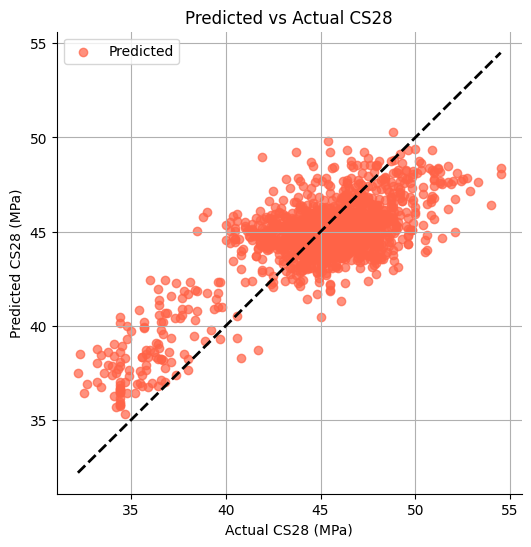

<IPython.core.display.Javascript object>

In [15]:
test_data = df_pred[df_pred["SET"] == "TEST"]

plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"], test_data["CS28_PRED"], color="tomato", alpha=0.7, label="Predicted"
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black", linestyle="--", linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig("ecics_207_at_local_cm_p_tiss_top_scpm_pred_vs_actual_cs28.png", dpi=300, bbox_inches='tight')
plt.show()


In [16]:
df["Cement_Type"].value_counts()

Cement_Type
CPIII40    814
CPVARI     781
CPIIF32    134
Name: count, dtype: int64

<IPython.core.display.Javascript object>

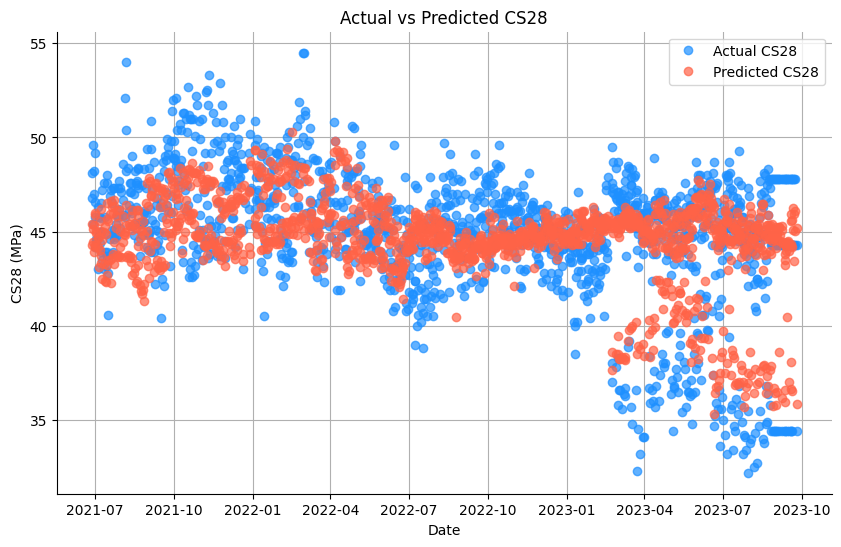

<IPython.core.display.Javascript object>

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
)
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
)
plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
plt.title("Actual vs Predicted CS28")
plt.legend(loc="best")
plt.grid(True)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_207_at_local_cm_p_tiss_top_scpm_pred_vs_actual_cs28_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


## Assessing Feature Importance

In [18]:
df_coefs, df_bias = get_linreg_df_importances(scores)
df_importances = df_coefs

<IPython.core.display.Javascript object>

In [19]:
df_importances

,CaO,MgO,Na2O,Al2O3,SiO2,SO3,K2O,Fe2O3,Loss on Ignition,Insoluble Residue,Blaine,#200,#400,Specific Gravity,Initial setting time,Final setting time
Coefficients - 0,0.345897,0.056597,0.334061,-3.035589,1.206485,1.026943,-1.084996,0.051856,-0.561623,0.174636,0.274723,0.112243,-0.202814,-0.028946,1.038847,-0.311197
Coefficients - 1,0.252069,0.276235,0.671825,-1.336870,-0.181221,1.296945,-1.389521,0.567912,-0.618185,0.300948,0.241866,0.602769,-0.354193,0.166714,1.720203,-1.467603
Coefficients - 2,0.380403,0.155543,0.614692,-2.584881,0.965873,1.175456,-0.878058,-0.453195,-0.818280,0.122748,0.098142,0.673801,-0.447341,0.379793,1.268680,-1.028800
Coefficients - 3,0.377639,-0.119377,0.771538,-2.068760,0.802166,1.030488,-0.553593,-0.216731,-0.638046,0.024915,0.180612,0.667506,-0.377917,0.107539,1.245772,-1.039973
Coefficients - 4,1.367053,-0.234520,1.063462,-1.549248,0.103216,1.077724,-0.680955,-1.001019,-1.857204,0.000850,0.308562,0.678908,-0.431841,0.034273,1.052456,-0.913546


<IPython.core.display.Javascript object>

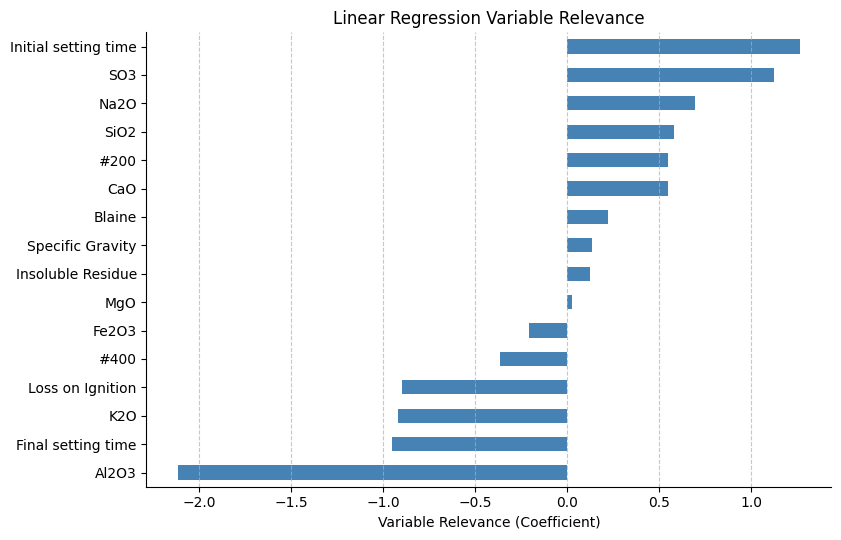

<IPython.core.display.Javascript object>

In [20]:
df_importances.mean(axis=0).sort_values().plot(
    kind="barh", figsize=(10, 5.5), color="steelblue"  # Consider using 'steelblue'
)
plt.title("Linear Regression Variable Relevance")
plt.xlabel("Variable Relevance (Coefficient)")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.subplots_adjust(left=0.3)
plt.show()

In [21]:
warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

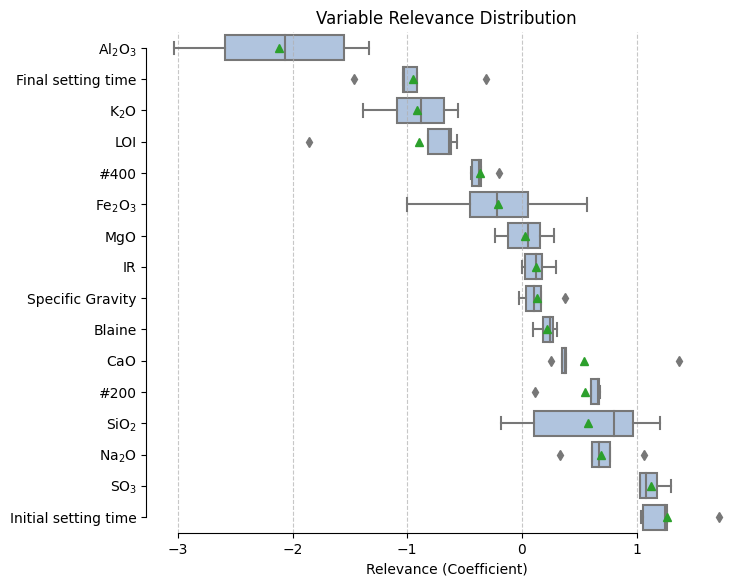

<IPython.core.display.Javascript object>

In [22]:
# Calculate the means of the importance scores
mean_importances = df_importances.mean()

# Sort the features by their mean relevance
sorted_features = mean_importances.sort_values()

# Re-order the DataFrame according to the sorted features
df_importances_sorted = df_importances[sorted_features.index]

# Backup the original backend
original_backend = plt.get_backend()

# Use Matplotlib's default backend
# plt.switch_backend("agg")  # or any backend you prefer

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)


# Convert chemical formulas using MathText syntax
df_importances_sorted_plot = df_importances_sorted.rename(
    columns={
        "Alpha C2S": r"Alpha $\mathrm{C_2S}$",
        "Beta C2S": r"Beta $\mathrm{C_2S}$",
        "Gamma C2S": r"Gamma $\mathrm{C_2S}$",
        "Cubic C3A": r"Cubic $\mathrm{C_3A}$",
        "Orthorhombic C3A": r"Orthorhombic $\mathrm{C_3A}$",
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
        "Loss on Ignition": "LOI",
    }
)

plt.figure(figsize=(10, 6.5))
sns.boxplot(
    data=df_importances_sorted_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (Coefficient)")
plt.title("Variable Relevance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)

plt.savefig(
    "ecics_207_at_local_cm_p_tiss_top_scpm_dist_var_coef_relevance.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

In [23]:
df_importances

,CaO,MgO,Na2O,Al2O3,SiO2,SO3,K2O,Fe2O3,Loss on Ignition,Insoluble Residue,Blaine,#200,#400,Specific Gravity,Initial setting time,Final setting time
Coefficients - 0,0.345897,0.056597,0.334061,-3.035589,1.206485,1.026943,-1.084996,0.051856,-0.561623,0.174636,0.274723,0.112243,-0.202814,-0.028946,1.038847,-0.311197
Coefficients - 1,0.252069,0.276235,0.671825,-1.336870,-0.181221,1.296945,-1.389521,0.567912,-0.618185,0.300948,0.241866,0.602769,-0.354193,0.166714,1.720203,-1.467603
Coefficients - 2,0.380403,0.155543,0.614692,-2.584881,0.965873,1.175456,-0.878058,-0.453195,-0.818280,0.122748,0.098142,0.673801,-0.447341,0.379793,1.268680,-1.028800
Coefficients - 3,0.377639,-0.119377,0.771538,-2.068760,0.802166,1.030488,-0.553593,-0.216731,-0.638046,0.024915,0.180612,0.667506,-0.377917,0.107539,1.245772,-1.039973
Coefficients - 4,1.367053,-0.234520,1.063462,-1.549248,0.103216,1.077724,-0.680955,-1.001019,-1.857204,0.000850,0.308562,0.678908,-0.431841,0.034273,1.052456,-0.913546


<IPython.core.display.Javascript object>

In [24]:
df_importances.describe().T.sort_values(by=["mean"])

,count,mean,std,min,25%,50%,75%,max
Al2O3,5.0,-2.115070,0.706394,-3.035589,-2.584881,-2.068760,-1.549248,-1.336870
Final setting time,5.0,-0.952224,0.415810,-1.467603,-1.039973,-1.028800,-0.913546,-0.311197
K2O,5.0,-0.917425,0.331962,-1.389521,-1.084996,-0.878058,-0.680955,-0.553593
Loss on Ignition,5.0,-0.898667,0.544391,-1.857204,-0.818280,-0.638046,-0.618185,-0.561623
#400,5.0,-0.362821,0.097226,-0.447341,-0.431841,-0.377917,-0.354193,-0.202814
Fe2O3,5.0,-0.210235,0.582799,-1.001019,-0.453195,-0.216731,0.051856,0.567912
MgO,5.0,0.026896,0.205753,-0.234520,-0.119377,0.056597,0.155543,0.276235
Insoluble Residue,5.0,0.124819,0.121302,0.000850,0.024915,0.122748,0.174636,0.300948
Specific Gravity,5.0,0.131875,0.157050,-0.028946,0.034273,0.107539,0.166714,0.379793
Blaine,5.0,0.220781,0.083237,0.098142,0.180612,0.241866,0.274723,0.308562


<IPython.core.display.Javascript object>

In [25]:
from sklearn.inspection import permutation_importance

<IPython.core.display.Javascript object>

In [26]:
# Initialize lists to store importance results
mdi_importances = []
perm_importances = []

# Compute feature importances
for i, (train_idx, test_idx) in enumerate(cv.split(x, y)):
    pipeline.fit(x.iloc[train_idx], y[train_idx])

    # Extract the trained model
    model = pipeline.named_steps["estimator"]
    imputer = pipeline.named_steps["imputer"]
    scaler = pipeline.named_steps["transformer"]
    # Compute MDI importance
    # mdi_importances.append(model.feature_importances_)

    # Compute permutation importance
    result = permutation_importance(
        model,
        scaler.transform(imputer.transform(x.iloc[test_idx])),
        y[test_idx],
        n_repeats=10,
        random_state=SEED,
        n_jobs=-1,
        # scoring="neg_mean_squared_error",
        scoring="r2",
    )
    perm_importances.append(result.importances_mean)

<IPython.core.display.Javascript object>

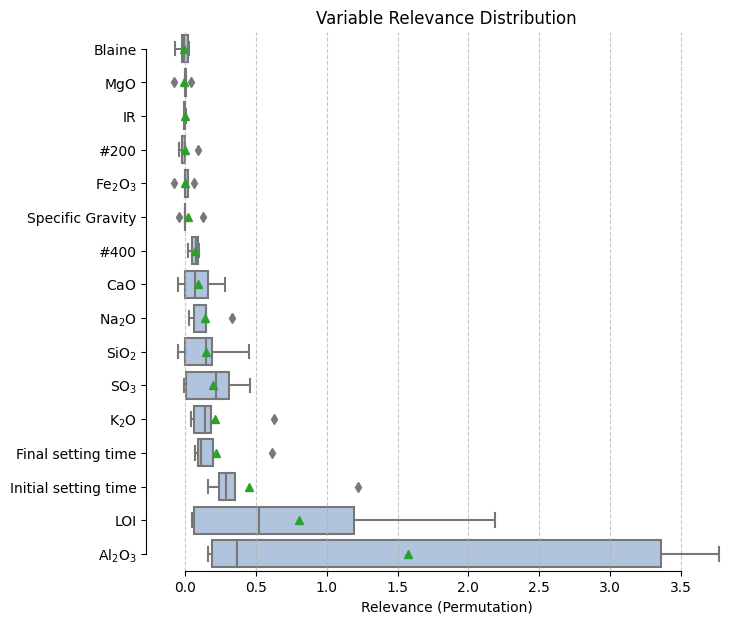

<IPython.core.display.Javascript object>

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# Convert lists to DataFrames
perm_importances_df = pd.DataFrame(perm_importances, columns=x.columns)


# Calculate the mean importance for each feature
mean_importances = perm_importances_df.mean().sort_values()

# Reorder the DataFrame columns based on mean importance
perm_importances_df = perm_importances_df[mean_importances.index]

perm_importances_df = perm_importances_df.rename(columns={"Loss on Ignition": "LOI"})


# Backup the original backend
original_backend = plt.get_backend()

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)

# Convert chemical formulas using MathText syntax
perm_importances_df_plot = perm_importances_df.rename(
    columns={
        "Alpha C2S": r"Alpha $\mathrm{C_2S}$",
        "Beta C2S": r"Beta $\mathrm{C_2S}$",
        "Gamma C2S": r"Gamma $\mathrm{C_2S}$",
        "Cubic C3A": r"Cubic $\mathrm{C_3A}$",
        "Orthorhombic C3A": r"Orthorhombic $\mathrm{C_3A}$",
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
    }
)

plt.figure(figsize=(10, 7))

# Create boxplot
sns.boxplot(
    data=perm_importances_df_plot.round(2),
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)

# Set x-axis label and title
plt.xlabel("Relevance (Permutation)")
plt.title("Variable Relevance Distribution")

# Add gridlines for x-axis
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Format x-axis to show 1 decimal place
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:.1f}"))

# Adjust the layout to prevent label cut-off
plt.subplots_adjust(left=0.3)

# Save the plot
plt.savefig(
    "ecics_207_at_local_cm_p_tiss_top_scpm_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)

# Show the plot
plt.show()

# Reset all rcParams to their default values
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

In [28]:
perm_importances_df.describe().round(4).T.sort_values(by="mean")

,count,mean,std,min,25%,50%,75%,max
Blaine,5.0,-0.0111,0.0405,-0.0728,-0.0186,-0.0146,0.0225,0.0283
MgO,5.0,-0.0047,0.0457,-0.0797,-0.0020,0.0008,0.0135,0.0440
Insoluble Residue,5.0,-0.0010,0.0092,-0.0109,-0.0075,-0.0001,0.0006,0.0131
#200,5.0,-0.0006,0.0542,-0.0444,-0.0242,-0.0230,-0.0043,0.0929
Fe2O3,5.0,0.0004,0.0508,-0.0789,-0.0010,0.0036,0.0169,0.0617
Specific Gravity,5.0,0.0191,0.0621,-0.0354,-0.0016,0.0015,0.0046,0.1264
#400,5.0,0.0669,0.0335,0.0160,0.0524,0.0758,0.0917,0.0984
CaO,5.0,0.0907,0.1311,-0.0532,0.0033,0.0650,0.1611,0.2771
Na2O,5.0,0.1423,0.1172,0.0272,0.0606,0.1464,0.1482,0.3293
SiO2,5.0,0.1485,0.1929,-0.0452,0.0026,0.1519,0.1871,0.4461


<IPython.core.display.Javascript object>

In [29]:
perm_importances_df

,Blaine,MgO,Insoluble Residue,#200,Fe2O3,Specific Gravity,#400,CaO,Na2O,SiO2,SO3,K2O,Final setting time,Initial setting time,LOI,Al2O3
0,0.022467,0.000803,0.013081,-0.004335,0.003608,-0.001563,0.016037,0.065046,0.027160,0.446122,0.455421,0.178147,0.065185,0.347768,0.061405,3.356761
1,-0.072843,0.044004,0.000553,0.092880,-0.078900,-0.035447,0.052449,-0.053212,0.329321,-0.045160,0.217522,0.627673,0.197454,1.216043,0.519385,0.163102
2,0.028284,-0.079690,-0.010866,-0.023000,-0.001027,0.126379,0.075834,0.161127,0.148204,0.187138,0.314442,0.138362,0.606358,0.286881,0.048813,3.769243
3,-0.014639,0.013546,-0.007475,-0.044442,0.016882,0.004649,0.098421,0.003275,0.146408,0.151852,-0.013370,0.055265,0.085317,0.241232,1.189939,0.367221
4,-0.018580,-0.001974,-0.000123,-0.024247,0.061654,0.001452,0.091690,0.277105,0.060598,0.002626,0.013030,0.037137,0.109778,0.156324,2.185673,0.188879


<IPython.core.display.Javascript object>